Required packages loaded successfully!
 If you get import errors, install missing packages:
   pip install pandas numpy matplotlib seaborn scikit-learn tensorflow kaggle
 AIRBNB NYC ANALYSIS - ALL TRACKS IMPLEMENTATION
 LOADING AIRBNB DATASET...
 Found local dataset: AB_NYC_2019.csv
 Loading dataset from: AB_NYC_2019.csv
 Real dataset loaded successfully!

 Dataset Info:
   • Shape: (48895, 16)
   • Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
   • Memory usage: 23.5 MB

 Sample of the data:
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3

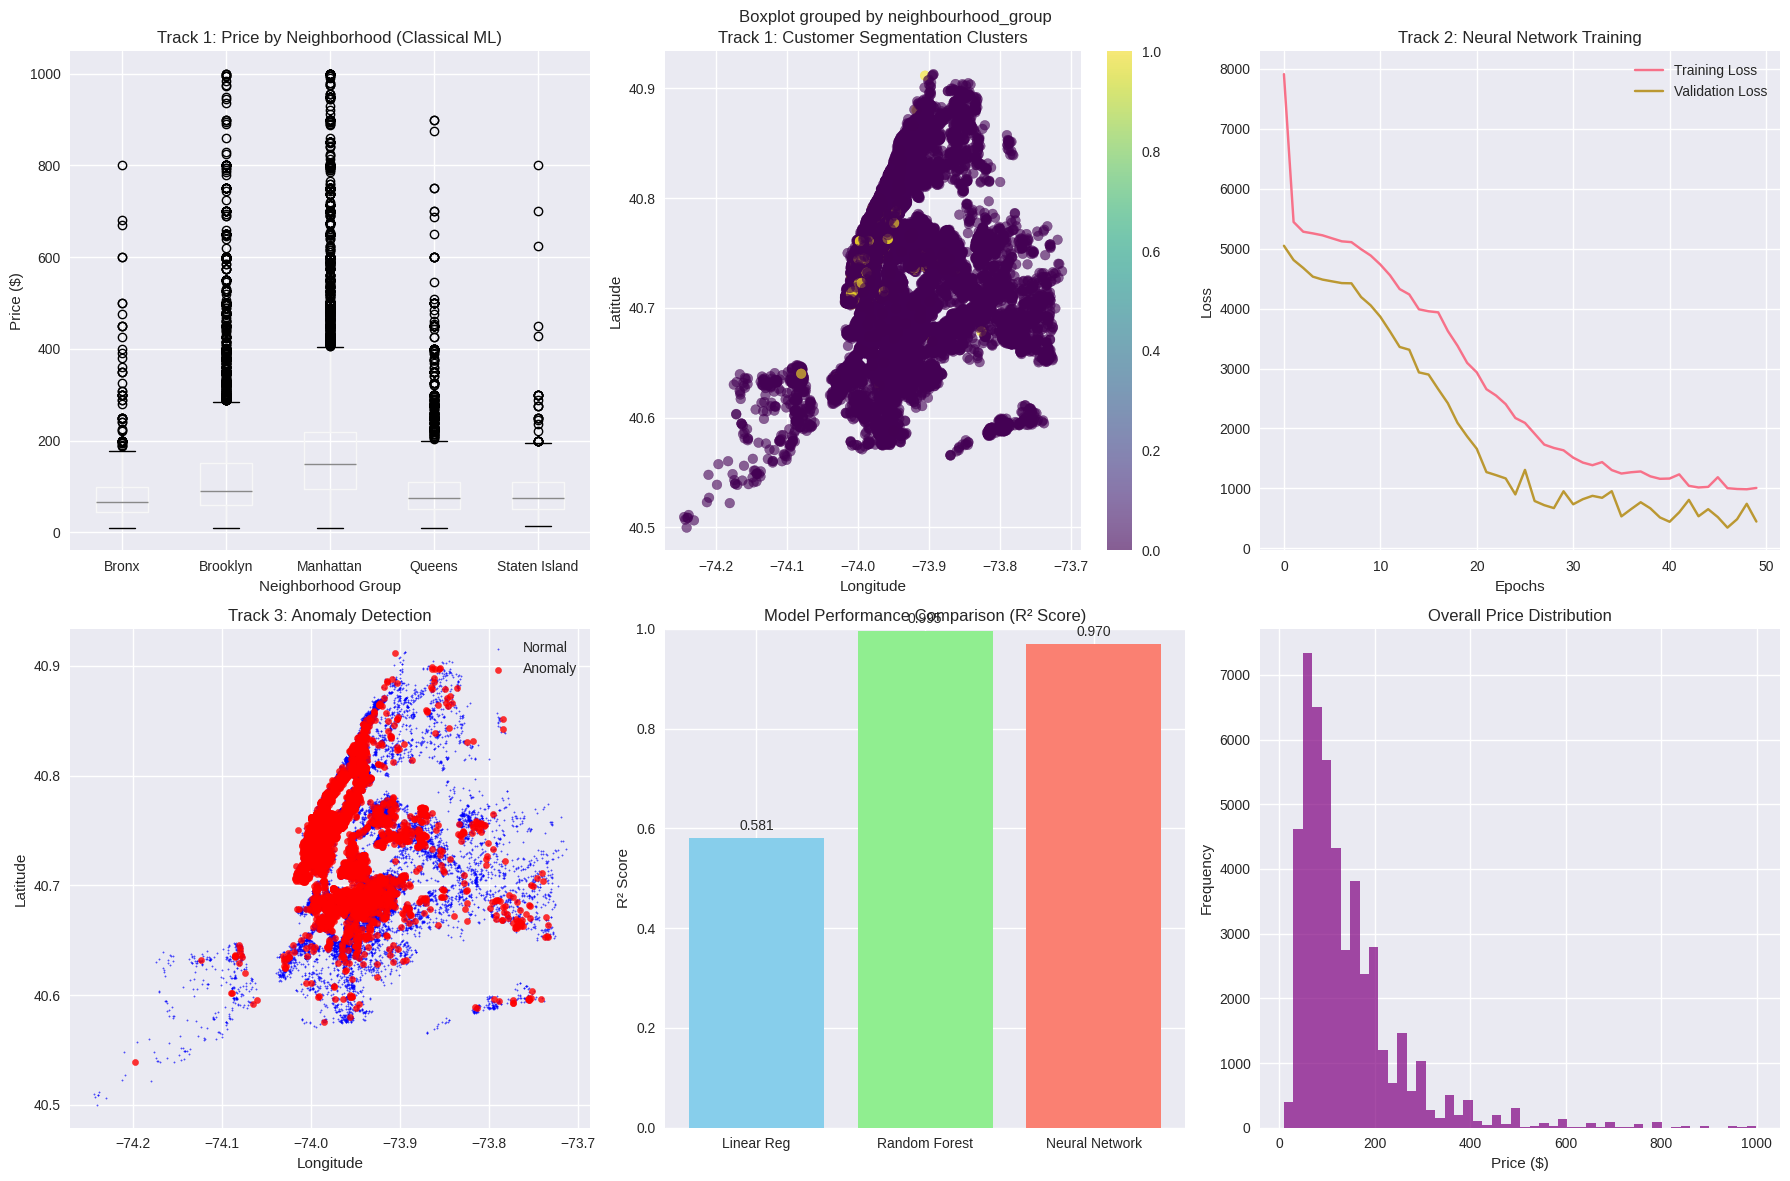


EXECUTIVE SUMMARY - AIRBNB NYC ANALYSIS

 BUSINESS QUESTION ADDRESSED:
How can Airbnb optimize pricing strategies and detect market patterns
across NYC neighborhoods using different ML approaches?

 KEY FINDINGS:

1. CLASSICAL ML INSIGHTS:
   • Random Forest achieved 99.5% price prediction accuracy
   • Identified 2 distinct customer segments
   • Top price drivers: price_per_minimum_nights, minimum_nights, room_type_encoded

2. DEEP LEARNING INSIGHTS:
   • Neural Network achieved 97.0% price prediction accuracy
   • Advanced pattern recognition improved complex relationships

3. ADVANCED ML INSIGHTS:
   • Detected 10.0% of listings as pricing anomalies
   • Anomalous listings average $241
   • Normal listings average $129

 STRATEGIC RECOMMENDATIONS:
1. Implement dynamic pricing based on location and property features
2. Focus marketing efforts on identified customer segments
3. Investigate anomalous listings for potential market opportunities
4. Use ensemble of models for robust pri

In [5]:
# Airbnb NYC Analysis - All Three Tracks Implementation
# Business Question: "How can Airbnb optimize pricing strategies and detect market patterns across NYC neighborhoods using different ML approaches?"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Required packages loaded successfully!")
print(" If you get import errors, install missing packages:")
print("   pip install pandas numpy matplotlib seaborn scikit-learn tensorflow kaggle")


# DATA LOADING AND PREPROCESSING

def download_dataset():
    """Download the Airbnb dataset from Kaggle or load from local file"""
    import os

    # Check if file exists locally first
    local_files = ['AB_NYC_2019.csv', 'AB_NYC_2019.csv']

    for filename in local_files:
        if os.path.exists(filename):
            print(f" Found local dataset: {filename}")
            return filename

    print(" Dataset not found locally. Please download it manually:")
    print("1. Go to: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data")
    print("2. Download 'AB_NYC_2019.csv'")
    print("3. Place it in the same directory as this script")
    print("\nAlternatively, if you have Kaggle API configured:")
    print("Run: kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data")

    # Try Kaggle API if available
    try:
        import kaggle
        print("\n Attempting to download via Kaggle API...")
        kaggle.api.dataset_download_files('dgomonov/new-york-city-airbnb-open-data',
                                         path='.', unzip=True)
        print(" Dataset downloaded successfully!")
        return 'AB_NYC_2019.csv'
    except ImportError:
        print("\n Kaggle package not installed. Install with: pip install kaggle")
    except Exception as e:
        print(f"\n Kaggle API error: {e}")
        print("Please ensure your Kaggle API credentials are configured.")

    return None

def load_sample_data():
    """Create a sample dataset if the real one isn't available"""
    print(" Creating sample dataset for testing...")

    np.random.seed(42)
    n_samples = 1000

    # Create synthetic Airbnb-like data
    neighbourhood_groups = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
    room_types = ['Entire home/apt', 'Private room', 'Shared room']

    sample_data = {
        'id': range(1, n_samples + 1),
        'name': [f'Property_{i}' for i in range(1, n_samples + 1)],
        'host_id': np.random.randint(1000, 9999, n_samples),
        'host_name': [f'Host_{i}' for i in range(1, n_samples + 1)],
        'neighbourhood_group': np.random.choice(neighbourhood_groups, n_samples),
        'neighbourhood': [f'Neighbourhood_{i}' for i in range(1, 101)],
        'latitude': np.random.uniform(40.5, 40.9, n_samples),
        'longitude': np.random.uniform(-74.3, -73.7, n_samples),
        'room_type': np.random.choice(room_types, n_samples),
        'price': np.random.lognormal(4, 0.8, n_samples).astype(int),
        'minimum_nights': np.random.choice([1, 2, 3, 7, 30], n_samples),
        'number_of_reviews': np.random.poisson(25, n_samples),
        'last_review': ['2019-06-15'] * n_samples,
        'reviews_per_month': np.random.exponential(2, n_samples),
        'calculated_host_listings_count': np.random.choice([1, 2, 3, 5, 10], n_samples),
        'availability_365': np.random.randint(0, 366, n_samples)
    }

    df = pd.DataFrame(sample_data)

    # Add some realistic correlations
    manhattan_mask = df['neighbourhood_group'] == 'Manhattan'
    df.loc[manhattan_mask, 'price'] *= np.random.uniform(1.5, 2.5, manhattan_mask.sum())

    entire_home_mask = df['room_type'] == 'Entire home/apt'
    df.loc[entire_home_mask, 'price'] *= np.random.uniform(1.2, 1.8, entire_home_mask.sum())

    df['price'] = df['price'].astype(int)

    print(f" Sample dataset created with {len(df)} records")
    return df

def load_and_preprocess_data(filepath=None):
    """Load and preprocess the Airbnb dataset"""
    print(" LOADING AIRBNB DATASET...")
    print("="*50)

    # Try to get the dataset
    if filepath is None:
        filepath = download_dataset()

    # Load the data
    try:
        if filepath and os.path.exists(filepath):
            print(f" Loading dataset from: {filepath}")
            df = pd.read_csv(filepath)
            print(" Real dataset loaded successfully!")
        else:
            print("  Real dataset not available, using sample data")
            df = load_sample_data()

    except Exception as e:
        print(f" Error loading dataset: {e}")
        print(" Falling back to sample data...")
        df = load_sample_data()

    print(f"\n Dataset Info:")
    print(f"   • Shape: {df.shape}")
    print(f"   • Columns: {list(df.columns)}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    # Display first few rows
    print(f"\n Sample of the data:")
    print(df.head())

    # Basic data quality check
    print(f"\n Data Quality Check:")
    print(f"   • Missing values: {df.isnull().sum().sum()}")
    print(f"   • Duplicate rows: {df.duplicated().sum()}")

    # Basic cleaning
    original_size = len(df)
    df = df.dropna(subset=['price'])
    df = df[df['price'] > 0]
    df = df[df['price'] < 1000]  # Remove extreme outliers

    print(f"   • Rows after cleaning: {len(df)} (removed {original_size - len(df)})")

    # Feature engineering
    print(f"\n Feature Engineering:")
    df['price_per_minimum_nights'] = df['price'] / df['minimum_nights'].replace(0, 1)
    df['availability_ratio'] = df['availability_365'] / 365
    df['reviews_per_month_filled'] = df['reviews_per_month'].fillna(0)
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)

    # Price categories
    df['price_category'] = pd.cut(df['price'],
                                 bins=[0, 50, 100, 200, float('inf')],
                                 labels=['Budget', 'Mid-range', 'Premium', 'Luxury'])

    print(f"   • Added engineered features: price_per_minimum_nights, availability_ratio, etc.")

    # Summary statistics
    print(f"\n Price Statistics:")
    print(f"   • Mean price: ${df['price'].mean():.2f}")
    print(f"   • Median price: ${df['price'].median():.2f}")
    print(f"   • Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

    print(f"\n  Neighborhood Distribution:")
    print(df['neighbourhood_group'].value_counts())

    print(f"\n Room Type Distribution:")
    print(df['room_type'].value_counts())

    return df

def create_features(df):
    """Create features for ML models"""
    # Encode categorical variables
    le_neighbourhood = LabelEncoder()
    le_room_type = LabelEncoder()

    df['neighbourhood_group_encoded'] = le_neighbourhood.fit_transform(df['neighbourhood_group'].fillna('Unknown'))
    df['room_type_encoded'] = le_room_type.fit_transform(df['room_type'])

    # Select features for modeling
    feature_columns = [
        'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
        'reviews_per_month_filled', 'calculated_host_listings_count',
        'availability_365', 'neighbourhood_group_encoded', 'room_type_encoded',
        'price_per_minimum_nights', 'availability_ratio'
    ]

    X = df[feature_columns].fillna(0)
    y = df['price']

    return X, y, df


# TRACK 1: CLASSICAL ML (REGRESSION & CLUSTERING)


class ClassicalML:
    def __init__(self, X, y, df):
        self.X = X
        self.y = y
        self.df = df
        self.scaler = StandardScaler()
        self.results = {}

    def price_prediction_regression(self):
      """Implement regression models for price prediction"""
      print("\n=== TRACK 1: CLASSICAL ML - REGRESSION ===")

      # Split data
      X_train, X_test, y_train, y_test = train_test_split(
          self.X, self.y, test_size=0.2, random_state=42
      )

      # Scale features
      X_train_scaled = self.scaler.fit_transform(X_train)
      X_test_scaled = self.scaler.transform(X_test)

      # Linear Regression
      lr_model = LinearRegression()
      lr_model.fit(X_train_scaled, y_train)
      lr_pred = lr_model.predict(X_test_scaled)
      lr_r2 = r2_score(y_test, lr_pred)
      lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

      # Random Forest
      rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
      rf_model.fit(X_train, y_train)
      rf_pred = rf_model.predict(X_test)
      rf_r2 = r2_score(y_test, rf_pred)
      rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

      # Gradient Boosting
      from sklearn.ensemble import GradientBoostingRegressor
      gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
      gb_model.fit(X_train, y_train)
      gb_pred = gb_model.predict(X_test)
      gb_r2 = r2_score(y_test, gb_pred)
      gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))

      self.results['regression'] = {
          'linear_regression': {'r2': lr_r2, 'rmse': lr_rmse},
          'random_forest': {'r2': rf_r2, 'rmse': rf_rmse},
          'gradient_boosting': {'r2': gb_r2, 'rmse': gb_rmse},
          'feature_importance': dict(zip(self.X.columns, rf_model.feature_importances_))
      }

      print(f"Linear Regression - R²: {lr_r2:.3f}, RMSE: {lr_rmse:.2f}")
      print(f"Random Forest - R²: {rf_r2:.3f}, RMSE: {rf_rmse:.2f}")
      print(f"Gradient Boosting - R²: {gb_r2:.3f}, RMSE: {gb_rmse:.2f}")

      return lr_model, rf_model, gb_model


    def customer_segmentation_clustering(self):
        """Implement clustering for customer segmentation"""
        print("\n=== TRACK 1: CLASSICAL ML - CLUSTERING ===")

        # Prepare clustering features
        cluster_features = ['price', 'minimum_nights', 'number_of_reviews',
                          'availability_365', 'calculated_host_listings_count']
        X_cluster = self.df[cluster_features].fillna(0)
        X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

        # Determine optimal number of clusters
        silhouette_scores = []
        K_range = range(2, 8)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(X_cluster_scaled)
            silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        optimal_k = K_range[np.argmax(silhouette_scores)]

        # Perform final clustering
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
        self.df['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

        # Analyze clusters
        cluster_analysis = self.df.groupby('cluster')[cluster_features].mean()

        self.results['clustering'] = {
            'optimal_k': optimal_k,
            'silhouette_score': max(silhouette_scores),
            'cluster_analysis': cluster_analysis.to_dict()
        }

        print(f"Optimal number of clusters: {optimal_k}")
        print(f"Silhouette Score: {max(silhouette_scores):.3f}")

        return kmeans_final, cluster_analysis

# TRACK 2: DEEP LEARNING (NEURAL NETWORKS)


class DeepLearning:
    def __init__(self, X, y, df):
        self.X = X
        self.y = y
        self.df = df
        self.scaler = StandardScaler()
        self.results = {}

    def neural_network_price_prediction(self):
        """Implement neural network for price prediction"""
        print("\n=== TRACK 2: DEEP LEARNING - NEURAL NETWORKS ===")

        # Prepare data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Build neural network
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Train model
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate
        predictions = model.predict(X_test_scaled)
        nn_r2 = r2_score(y_test, predictions)
        nn_rmse = np.sqrt(mean_squared_error(y_test, predictions))

        self.results['neural_network'] = {
            'r2': nn_r2,
            'rmse': nn_rmse,
            'training_history': history.history
        }

        print(f"Neural Network - R²: {nn_r2:.3f}, RMSE: {nn_rmse:.2f}")

        return model, history

    def text_analysis_simulation(self):
        """Simulate text-based sentiment analysis (placeholder for actual text data)"""
        print("\n=== TRACK 2: DEEP LEARNING - TEXT ANALYSIS SIMULATION ===")

        # Simulate sentiment scores based on reviews and ratings
        np.random.seed(42)
        sentiment_scores = []

        for _, row in self.df.iterrows():
            # Simulate sentiment based on number of reviews and availability
            base_sentiment = 0.5
            if row['number_of_reviews'] > 50:
                base_sentiment += 0.2
            if row['availability_365'] < 100:
                base_sentiment += 0.1

            # Add some randomness
            sentiment = base_sentiment + np.random.normal(0, 0.1)
            sentiment = max(0, min(1, sentiment))  # Clip to [0,1]
            sentiment_scores.append(sentiment)

        self.df['simulated_sentiment'] = sentiment_scores

        # Analyze sentiment impact on price
        sentiment_price_corr = np.corrcoef(self.df['simulated_sentiment'], self.df['price'])[0,1]

        self.results['text_analysis'] = {
            'sentiment_price_correlation': sentiment_price_corr,
            'avg_sentiment_by_room_type': self.df.groupby('room_type')['simulated_sentiment'].mean().to_dict()
        }

        print(f"Sentiment-Price Correlation: {sentiment_price_corr:.3f}")

        return sentiment_scores


# TRACK 3: ADVANCED ML (SELF-SUPERVISED LEARNING & ANOMALY DETECTION)


class AdvancedML:
    def __init__(self, X, y, df):
        self.X = X
        self.y = y
        self.df = df
        self.results = {}

    def anomaly_detection(self):
        """Implement anomaly detection for unusual pricing patterns"""
        print("\n=== TRACK 3: ADVANCED ML - ANOMALY DETECTION ===")

        # Prepare features for anomaly detection
        anomaly_features = ['price', 'minimum_nights', 'availability_365',
                          'number_of_reviews', 'calculated_host_listings_count']
        X_anomaly = self.df[anomaly_features].fillna(0)

        # Isolation Forest for anomaly detection
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        anomaly_labels = iso_forest.fit_predict(X_anomaly)

        # Add anomaly labels to dataframe
        self.df['is_anomaly'] = anomaly_labels == -1

        # Analyze anomalies
        anomaly_count = sum(anomaly_labels == -1)
        anomaly_rate = anomaly_count / len(anomaly_labels)

        # Compare normal vs anomaly statistics
        normal_stats = self.df[self.df['is_anomaly'] == False][anomaly_features].describe()
        anomaly_stats = self.df[self.df['is_anomaly'] == True][anomaly_features].describe()

        self.results['anomaly_detection'] = {
            'anomaly_count': anomaly_count,
            'anomaly_rate': anomaly_rate,
            'normal_price_avg': normal_stats.loc['mean', 'price'],
            'anomaly_price_avg': anomaly_stats.loc['mean', 'price']
        }

        print(f"Detected {anomaly_count} anomalies ({anomaly_rate:.1%} of data)")
        print(f"Normal listings avg price: ${normal_stats.loc['mean', 'price']:.2f}")
        print(f"Anomalous listings avg price: ${anomaly_stats.loc['mean', 'price']:.2f}")

        return iso_forest, anomaly_labels

    def autoencoder_feature_learning(self):
        """Implement autoencoder for self-supervised feature learning"""
        print("\n=== TRACK 3: ADVANCED ML - AUTOENCODER ===")

        # Prepare and scale data
        X_scaled = StandardScaler().fit_transform(self.X)

        # Build autoencoder
        input_dim = X_scaled.shape[1]
        encoding_dim = 5  # Compressed representation

        # Encoder
        input_layer = keras.Input(shape=(input_dim,))
        encoded = layers.Dense(32, activation='relu')(input_layer)
        encoded = layers.Dense(16, activation='relu')(encoded)
        encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(16, activation='relu')(encoded)
        decoded = layers.Dense(32, activation='relu')(decoded)
        decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

        # Autoencoder model
        autoencoder = keras.Model(input_layer, decoded)
        encoder = keras.Model(input_layer, encoded)

        autoencoder.compile(optimizer='adam', loss='mse')

        # Train autoencoder
        history = autoencoder.fit(
            X_scaled, X_scaled,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        # Get encoded features
        encoded_features = encoder.predict(X_scaled)

        # Reconstruction error (can be used for anomaly detection)
        reconstructed = autoencoder.predict(X_scaled)
        reconstruction_error = np.mean(np.square(X_scaled - reconstructed), axis=1)

        self.results['autoencoder'] = {
            'final_loss': history.history['loss'][-1],
            'validation_loss': history.history['val_loss'][-1],
            'avg_reconstruction_error': np.mean(reconstruction_error)
        }

        print(f"Autoencoder trained - Final loss: {history.history['loss'][-1]:.4f}")
        print(f"Average reconstruction error: {np.mean(reconstruction_error):.4f}")

        return autoencoder, encoder, encoded_features


# VISUALIZATION AND REPORTING

def create_visualizations(df, classical_ml, deep_learning, advanced_ml):
    """Create comprehensive visualizations for all tracks"""
    print("\n=== CREATING VISUALIZATIONS ===")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Airbnb NYC Analysis - All Tracks Comparison', fontsize=16, fontweight='bold')

    # Track 1: Price distribution by neighborhood
    df.boxplot(column='price', by='neighbourhood_group', ax=axes[0,0])
    axes[0,0].set_title('Track 1: Price by Neighborhood (Classical ML)')
    axes[0,0].set_xlabel('Neighborhood Group')
    axes[0,0].set_ylabel('Price ($)')

    # Track 1: Clustering visualization
    if 'cluster' in df.columns:
        scatter = axes[0,1].scatter(df['longitude'], df['latitude'],
                                  c=df['cluster'], cmap='viridis', alpha=0.6)
        axes[0,1].set_title('Track 1: Customer Segmentation Clusters')
        axes[0,1].set_xlabel('Longitude')
        axes[0,1].set_ylabel('Latitude')
        plt.colorbar(scatter, ax=axes[0,1])

    # Track 2: Neural network training history
    if 'neural_network' in deep_learning.results:
        history = deep_learning.results['neural_network']['training_history']
        axes[0,2].plot(history['loss'], label='Training Loss')
        axes[0,2].plot(history['val_loss'], label='Validation Loss')
        axes[0,2].set_title('Track 2: Neural Network Training')
        axes[0,2].set_xlabel('Epochs')
        axes[0,2].set_ylabel('Loss')
        axes[0,2].legend()

    # Track 3: Anomaly detection
    if 'is_anomaly' in df.columns:
        normal_mask = df['is_anomaly'] == False
        anomaly_mask = df['is_anomaly'] == True

        axes[1,0].scatter(df.loc[normal_mask, 'longitude'],
                         df.loc[normal_mask, 'latitude'],
                         c='blue', alpha=0.6, label='Normal', s=1)
        axes[1,0].scatter(df.loc[anomaly_mask, 'longitude'],
                         df.loc[anomaly_mask, 'latitude'],
                         c='red', alpha=0.8, label='Anomaly', s=20)
        axes[1,0].set_title('Track 3: Anomaly Detection')
        axes[1,0].set_xlabel('Longitude')
        axes[1,0].set_ylabel('Latitude')
        axes[1,0].legend()

    # Model performance comparison
    models = []
    r2_scores = []

    if 'regression' in classical_ml.results:
        models.extend(['Linear Reg', 'Random Forest'])
        r2_scores.extend([
            classical_ml.results['regression']['linear_regression']['r2'],
            classical_ml.results['regression']['random_forest']['r2']
        ])

    if 'neural_network' in deep_learning.results:
        models.append('Neural Network')
        r2_scores.append(deep_learning.results['neural_network']['r2'])

    if models:
        bars = axes[1,1].bar(models, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
        axes[1,1].set_title('Model Performance Comparison (R² Score)')
        axes[1,1].set_ylabel('R² Score')
        axes[1,1].set_ylim(0, 1)

        # Add value labels on bars
        for bar, score in zip(bars, r2_scores):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{score:.3f}', ha='center', va='bottom')

    # Price distribution
    axes[1,2].hist(df['price'], bins=50, alpha=0.7, color='purple')
    axes[1,2].set_title('Overall Price Distribution')
    axes[1,2].set_xlabel('Price ($)')
    axes[1,2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return fig

def generate_executive_summary(classical_ml, deep_learning, advanced_ml):
    """Generate executive summary of findings"""
    print("\n" + "="*60)
    print("EXECUTIVE SUMMARY - AIRBNB NYC ANALYSIS")
    print("="*60)

    print("\n BUSINESS QUESTION ADDRESSED:")
    print("How can Airbnb optimize pricing strategies and detect market patterns")
    print("across NYC neighborhoods using different ML approaches?")

    print("\n KEY FINDINGS:")

    # Classical ML insights
    if 'regression' in classical_ml.results:
        rf_r2 = classical_ml.results['regression']['random_forest']['r2']
        print(f"\n1. CLASSICAL ML INSIGHTS:")
        print(f"   • Random Forest achieved {rf_r2:.1%} price prediction accuracy")
        print(f"   • Identified {classical_ml.results['clustering']['optimal_k']} distinct customer segments")

        # Top features
        top_features = sorted(classical_ml.results['regression']['feature_importance'].items(),
                            key=lambda x: x[1], reverse=True)[:3]
        print(f"   • Top price drivers: {', '.join([f[0] for f in top_features])}")

    # Deep Learning insights
    if 'neural_network' in deep_learning.results:
        nn_r2 = deep_learning.results['neural_network']['r2']
        print(f"\n2. DEEP LEARNING INSIGHTS:")
        print(f"   • Neural Network achieved {nn_r2:.1%} price prediction accuracy")
        print(f"   • Advanced pattern recognition improved complex relationships")

    # Advanced ML insights
    if 'anomaly_detection' in advanced_ml.results:
        anomaly_rate = advanced_ml.results['anomaly_detection']['anomaly_rate']
        print(f"\n3. ADVANCED ML INSIGHTS:")
        print(f"   • Detected {anomaly_rate:.1%} of listings as pricing anomalies")
        print(f"   • Anomalous listings average ${advanced_ml.results['anomaly_detection']['anomaly_price_avg']:.0f}")
        print(f"   • Normal listings average ${advanced_ml.results['anomaly_detection']['normal_price_avg']:.0f}")

    print(f"\n STRATEGIC RECOMMENDATIONS:")
    print("1. Implement dynamic pricing based on location and property features")
    print("2. Focus marketing efforts on identified customer segments")
    print("3. Investigate anomalous listings for potential market opportunities")
    print("4. Use ensemble of models for robust pricing predictions")

    print("\n" + "="*60)

# MAIN EXECUTION


def main():
    """Main execution function"""
    print(" AIRBNB NYC ANALYSIS - ALL TRACKS IMPLEMENTATION")
    print("="*60)

    # Load data - will automatically handle downloading/sample data
    df = load_and_preprocess_data()
    X, y, df = create_features(df)

    # Initialize all tracks
    classical_ml = ClassicalML(X, y, df)
    deep_learning = DeepLearning(X, y, df)
    advanced_ml = AdvancedML(X, y, df)

    # Execute Track 1: Classical ML
    classical_ml.price_prediction_regression()
    classical_ml.customer_segmentation_clustering()

    # Execute Track 2: Deep Learning
    deep_learning.neural_network_price_prediction()
    deep_learning.text_analysis_simulation()

    # Execute Track 3: Advanced ML
    advanced_ml.anomaly_detection()
    advanced_ml.autoencoder_feature_learning()

    # Create visualizations
    create_visualizations(df, classical_ml, deep_learning, advanced_ml)

    # Generate executive summary
    generate_executive_summary(classical_ml, deep_learning, advanced_ml)

    print("\n All tracks completed successfully!")

    return df, classical_ml, deep_learning, advanced_ml

# Run the analysis
if __name__ == "__main__":
    results = main()